In [1]:
from lib.MLP import *
import random

import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
mnist = fetch_openml('mnist_784', version=1, parser='auto')


In [3]:
X, y = mnist.data, mnist.target.astype(int)

X = X.to_numpy() / 255.0  
y = y.astype(int).to_numpy()  
def one_hot(y, num_classes=10):
    one_hot_encoded = np.zeros((y.shape[0], num_classes))
    one_hot_encoded[np.arange(y.shape[0]), y] = 1
    return one_hot_encoded

y = one_hot(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y,random_state=42)
num_data = 60000

# Split data (60,000 train, 10,000 test)
X_train, X_test = X[:num_data], X[num_data:]
y_train, y_test = y[:num_data], y[num_data:]
print(f"Dataset loaded: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")


Dataset loaded: 60000 training samples, 10000 test samples.


In [3]:
# Buat model
input_layer = Layer(input_size=784, n_neurons=8, activation='relu', bias_init='zeros',seed=42,weight_init='he_uniform')
hidden_layer_1 = Layer(input_size=8, n_neurons=8, activation='relu', bias_init='zeros',seed=42,weight_init='he_uniform')
hidden_layer_2 = Layer(input_size=8, n_neurons=4, activation='relu', bias_init='zeros',seed=42,weight_init='he_uniform')
output_layer = Layer(input_size=4, n_neurons=10, activation='softmax', bias_init='zeros',seed=42,weight_init='he_uniform')

layers = [input_layer, hidden_layer_1, hidden_layer_2,output_layer]

mlp = MLP(layers=layers, loss_function='cce',lr=0.1)

# Training model
mlp.train(X_train, y_train,X_val=X_test,y_val=y_test ,epochs=5, batch_size=100)

# Evaluasi di test set
test_acc = mlp.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}%")


Training: 100%|██████████| 10/10 [00:05<00:00,  1.67epoch/s, accuracy=89.43%, train_loss=0.4133, val_loss=0.4621]

Test Accuracy: 88.26%


In [ ]:
print("\nEvaluating original model...")
original_predictions = mlp.predict(X_test[:100])
y_test_indices = np.argmax(y_test[:100], axis=1)
original_accuracy = accuracy_score(y_test_indices, original_predictions)
print(f"Original model accuracy: {original_accuracy:.4f}")

print("\nSaving model...")
save_path = 'mnist_model.pkl'
mlp.save(save_path)
print(f"Model saved to {save_path}")

print("\nLoading model...")
loaded_model = MLP.load(save_path)

print("\nValidating loaded model...")
loaded_predictions = loaded_model.predict(X_test[:100])
loaded_accuracy = accuracy_score(y_test_indices, loaded_predictions)
print(f"Loaded model accuracy: {loaded_accuracy:.4f}")

is_identical = np.array_equal(original_predictions, loaded_predictions)
print(f"\nPredictions identical: {is_identical}")

print("\nComparing model parameters:")
all_params_match = True

if len(mlp.layers) != len(loaded_model.layers):
    print(f"Different number of layers: {len(mlp.layers)} vs {len(loaded_model.layers)}")
    all_params_match = False
else:
    for i, (orig_layer, loaded_layer) in enumerate(zip(mlp.layers, loaded_model.layers)):
        weights_match = np.array_equal(orig_layer.weights, loaded_layer.weights)
        biases_match = np.array_equal(orig_layer.biases, loaded_layer.biases)
        
        if weights_match and biases_match:
            print(f"Layer {i}: All parameters match ✓")
        else:
            which_diff = []
            if not weights_match: which_diff.append("weights")
            if not biases_match: which_diff.append("biases")
            print(f"Layer {i}: Parameters differ ({', '.join(which_diff)}) ✗")
            all_params_match = False

print(f"\nOverall parameter comparison: {'PASSED' if all_params_match else 'FAILED'}")

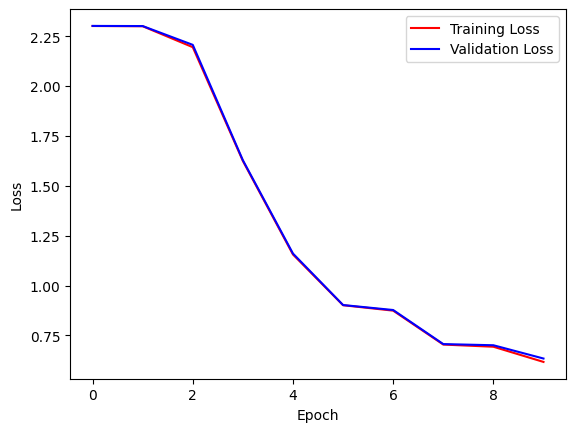

In [7]:
mlp.plot_loss()

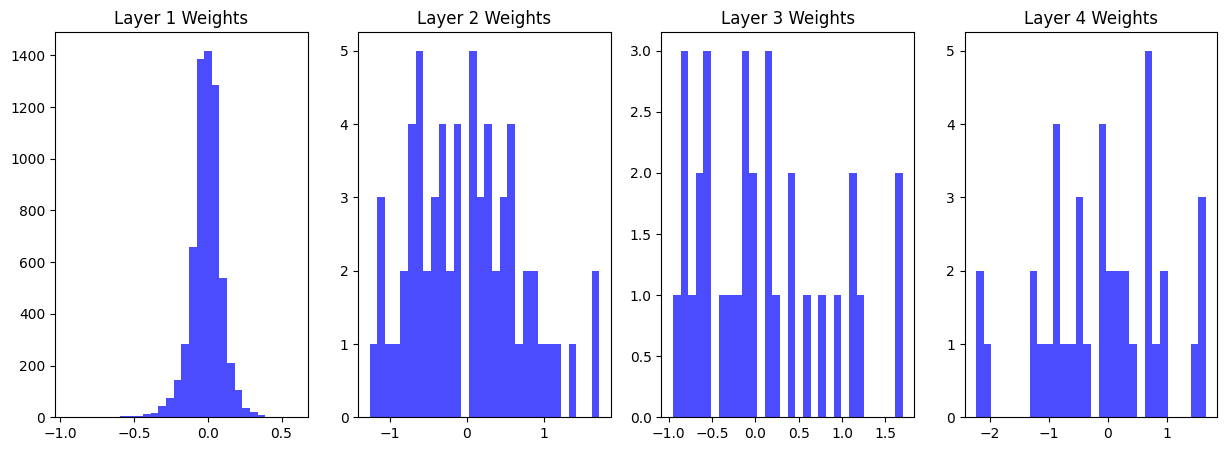

In [5]:
mlp.plot_weight_distribution()


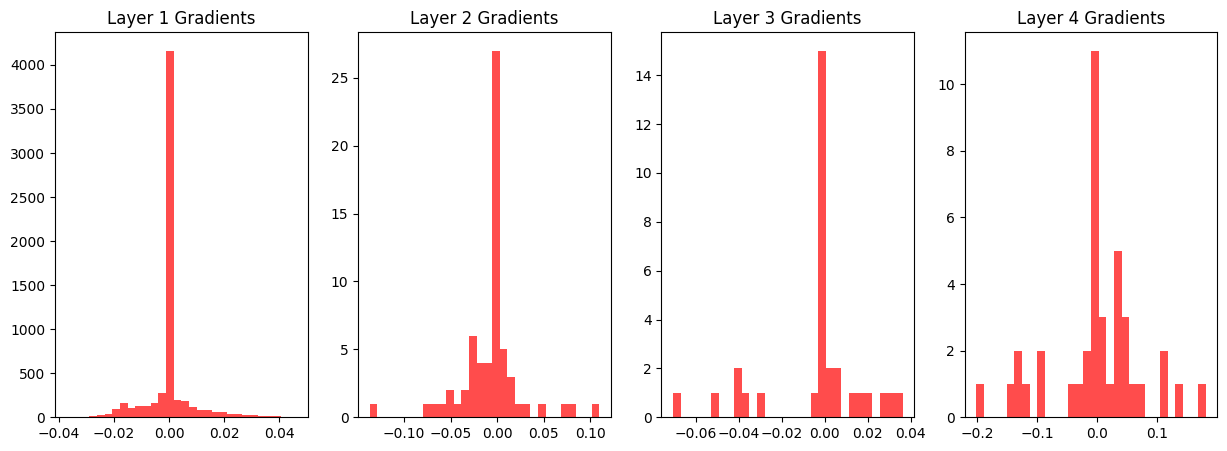

In [6]:
mlp.plot_gradient_distribution()